# Metadata to Get Inference Data for Experimentation

In [71]:
import os
import gc
import glob
import json
import utils
import pickle

import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from joblib import parallel_backend

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [8]:
pbar = ProgressBar()
pbar.register()
# client = Client()

In [9]:
# inferred int64 types cause a type mismatch (int vs float) error when dask sees a null value
# null values cannot be interpreted as ints
custom_dtypes = {
    "seagate": {
    "date": "object",
    "serial_number": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_184_normalized": "float32",
    "smart_184_raw": "float32",
    "smart_187_normalized": "float32",
    "smart_187_raw": "float32",
    "smart_188_normalized": "float32",
    "smart_188_raw": "float32",
    "smart_189_normalized": "float32",
    "smart_189_raw": "float32",
    "smart_190_normalized": "float32",
    "smart_190_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_240_normalized": "float32",
    "smart_240_raw": "float32",
    "smart_241_normalized": "float32",
    "smart_241_raw": "float32",
    "smart_242_normalized": "float32",
    "smart_242_raw": "float32"
},
    "hgst": {
    "date": "object",
    "serial_number": "object",
    "model": "object",
    "capacity_bytes": "float32",
    "failure": "float32",
    "smart_1_normalized": "float32",
    "smart_1_raw": "float32",
    "smart_2_normalized": "float32",
    "smart_2_raw": "float32",
    "smart_3_normalized": "float32",
    "smart_3_raw": "float32",
    "smart_4_normalized": "float32",
    "smart_4_raw": "float32",
    "smart_5_normalized": "float32",
    "smart_5_raw": "float32",
    "smart_7_normalized": "float32",
    "smart_7_raw": "float32",
    "smart_8_normalized": "float32",
    "smart_8_raw": "float32",
    "smart_9_normalized": "float32",
    "smart_9_raw": "float32",
    "smart_10_normalized": "float32",
    "smart_10_raw": "float32",
    "smart_12_normalized": "float32",
    "smart_12_raw": "float32",
    "smart_22_normalized": "float32",
    "smart_22_raw": "float32",
    "smart_192_normalized": "float32",
    "smart_192_raw": "float32",
    "smart_193_normalized": "float32",
    "smart_193_raw": "float32",
    "smart_194_normalized": "float32",
    "smart_194_raw": "float32",
    "smart_196_normalized": "float32",
    "smart_196_raw": "float32",
    "smart_197_normalized": "float32",
    "smart_197_raw": "float32",
    "smart_198_normalized": "float32",
    "smart_198_raw": "float32",
    "smart_199_normalized": "float32",
    "smart_199_raw": "float32"
}}

In [10]:
# read all the data into one dataframe
# NOTE: assumes aws credentials are stored as env vars or in ~/.aws/credentials
# TODO: move to reading from Ceph after slow read blocker is removed
DATA_ROOT_DIR = '/home/kachauha/Downloads/'
df4 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q4_2018_parquet'), engine='pyarrow', index=False)
df3 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q3_2018_parquet'), engine='pyarrow', index=False)
df2 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q2_2018_parquet'), engine='pyarrow', index=False)
df1 = dd.read_parquet(os.path.join(DATA_ROOT_DIR, 'data_Q1_2018_parquet'), engine='pyarrow', index=False)
df = dd.concat(dfs=[df1, df2, df3, df4], interleave_partitions=True)

# extract only seagate
seagate_df = utils.optimal_repartition_df(df[df['model'].str.startswith('S')])

[########################################] | 100% Completed |  1min 46.6s
[########################################] | 100% Completed |  1min 46.7s
[########################################] | 100% Completed |  1min 46.8s


In [11]:
# define thresholds as timedelta
BAD_THRESHOLD_NDAYS = np.timedelta64(14, 'D')
WARNING_THRESHOLD_NDAYS = np.timedelta64(42, 'D')

In [12]:
# get the serial numbers for all the failed hard drives
failed_serials = df[df['failure']==1]['serial_number'].compute()
working_serials = df[~df['serial_number'].isin(failed_serials)]['serial_number'].unique().compute()
# # failed drives data. how many rows of failed data
# failed_df = df[df['serial_number'].isin(failed_serials)]
# dd.compute(failed_df.shape)

[########################################] | 100% Completed | 47.6s
[########################################] | 100% Completed | 47.6s
[########################################] | 100% Completed | 47.7s


In [9]:
# convert from str to datetime
df['date'] = df['date'].astype('datetime64')

# =============================== FOR DASK =============================== #
# create meta of the resulting failed_df otherwise dask complains
rul_meta = df._meta
rul_meta = rul_meta.assign(rul_days=rul_meta['date'].max()-rul_meta['date'])
# ======================================================================== #

# get remaining useful life as diff(today, maxday)
# reset index coz result is multiindexed. drop=True coz serial_number already exists as a col
df = df.groupby('serial_number').apply(utils.append_rul_days_column, meta=rul_meta).reset_index(drop=True)

In [10]:
df.head()

[########################################] | 100% Completed | 44.2s


,date,serial_number,capacity_bytes,failure,smart_1_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_10_raw,smart_184_raw,...,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,rul_days
0,2018-07-05,6VDHZLVX,3.200729e+11,0.0,230008832.0,0.0,379141760.0,39351.0,0.0,0.0,...,100.0,71.0,1.0,29.0,100.0,100.0,-100.0,-100.0,-100.0,86 days
1,2018-07-06,6VDHZLVX,3.200729e+11,0.0,41241224.0,0.0,379282016.0,39376.0,0.0,0.0,...,100.0,72.0,1.0,28.0,100.0,100.0,-100.0,-100.0,-100.0,85 days
2,2018-07-07,6VDHZLVX,3.200729e+11,0.0,96913096.0,0.0,379423968.0,39401.0,0.0,0.0,...,100.0,72.0,1.0,28.0,100.0,100.0,-100.0,-100.0,-100.0,84 days
3,2018-07-08,6VDHZLVX,3.200729e+11,0.0,152480320.0,0.0,379562496.0,39425.0,0.0,0.0,...,100.0,72.0,1.0,28.0,100.0,100.0,-100.0,-100.0,-100.0,83 days
4,2018-07-01,6VDHZLVX,3.200729e+11,0.0,6682081.0,0.0,378571296.0,39254.0,0.0,0.0,...,100.0,71.0,1.0,29.0,100.0,100.0,-100.0,-100.0,-100.0,90 days


In [11]:
# for testing, keep only the drives which either failed or "working but had rul value at least >6weeks"
# NOTE: rul is meaningless for working drives. it's just used as a tool
test_sers = df[(df['serial_number'].isin(failed_serials)) | (df['rul_days']>=WARNING_THRESHOLD_NDAYS)]['serial_number'].unique().compute()
test_sers.to_csv('test_drive_serials.csv')

[########################################] | 100% Completed |  3min 27.8s


In [9]:
# how are failures spread out across dates
fail_date_ct = failed_df[failed_df['failure']==1]['date'].value_counts().compute()
fail_date_ct.shape

[########################################] | 100% Completed | 27.4s


(168,)

In [16]:
fail_date_ct.sort_values(ascending=False).head(15)

2018-12-10    13
2018-07-26    11
2018-12-07    10
2018-07-13     9
2018-11-19     9
2018-12-17     8
2018-11-26     8
2018-11-05     8
2018-08-03     8
2018-08-06     8
2018-07-07     8
2018-08-13     8
2018-12-22     8
2018-08-20     7
2018-12-19     7
Name: date, dtype: int64

In [14]:
# select a day on which considerable number of failures occured
FAIL_DATE = '2018-11-05'

# drives that failed on fail date
fail_date_sers = failed_df[(failed_df['date']==FAIL_DATE) & (failed_df['failure']==1)]['serial_number'].compute()

# lenght of life of drives rthat filaed on fail date
g = failed_df[failed_df['serial_number'].isin(fail_date_sers)][['serial_number', 'date']].groupby('serial_number')
g.size().compute()

[####                                    ] | 11% Completed |  4.2s


KeyboardInterrupt: 

In [8]:
# drives that have not failed  a of quarter end, and also whose serial beings with 'Z' (so that we choose drives of similar hd model types)
working_sers = df[(df['date']==FAIL_DATE) \
                  & ~df['serial_number'].isin(failed_serials) \
                  & (df['serial_number'].str.startswith('Z'))]\
                ['serial_number']
working_sers = working_sers.compute()
working_sers.head()

[########################################] | 100% Completed | 14.2s


0    Z305B2QN
1    ZJV0XJQ4
2    ZJV0XJQ0
3    ZA16NQJR
4    ZJV02XWG
Name: serial_number, dtype: object

In [52]:
df[df['serial_number']=='Z305B2QN']['date'].max().compute()

[########################################] | 100% Completed | 55.4s
[########################################] | 100% Completed | 55.5s
[########################################] | 100% Completed | 55.5s


Timestamp('2018-12-31 00:00:00')

In [13]:
# save susbet for failed drives
fail_test_df = utils.get_drive_data_from_json(fnames=glob.glob('smart_data_data_Q4_2018_2018-11-*.json'), serial_numbers=fail_date_sers)
fail_test_df.to_json('fail_test.json', orient='records', lines=True)

In [9]:
# save susbet for failed drives
working_test_df = utils.get_drive_data_from_json(fnames=glob.glob('smart_data_data_Q4_2018_2018-11-*.json'), serial_numbers=working_sers.sample(n=10))
working_test_df.to_json('working_test.json', orient='records', lines=True)

# Get inference data
This is the format of the current setup on ceph upstream. So get a tiny subsample from the dataset into this format

### Drivewise Data
Instead of jsons being datewise, we need them drivewise. Then n(=6) day window worth of data can be extracted in a sliding way

(array([736695., 736754., 736815., 736876., 736938., 736999., 737060.]),
 <a list of 7 Text xticklabel objects>)

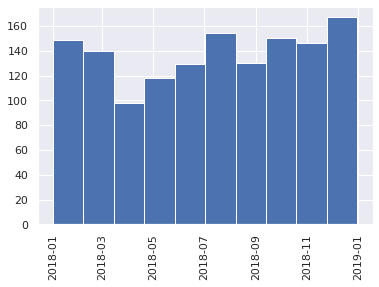

In [42]:
fail_dates = df[df['failure']==1]['date'].compute().astype(np.datetime64)
plt.hist(fail_dates)
plt.xticks(rotation=90)

**NOTE** most of the failed drives data comes from quarters 3 and 4. therefore start digging there first

In [87]:
# need to subsample otherwise we'l; end up with 125k files
failed_serials_sub = failed_serials.sample(n=50)
working_serials_sub = working_serials.sample(n=50)

In [88]:
# key=serial number, value=(dictionary with key=date, value=(dictioary with key=smartname, value=smartvalue))
failed_drive_datas = dict()
working_drive_datas = dict()

In [89]:
data_dirs = ['smart_data_Q4_2018']
for curr_quart_dir in data_dirs:
    for json_path in glob.glob(os.path.join(DATA_ROOT_DIR, curr_quart_dir, '*.json')):
        # read each file and check for relevant content
        with open(json_path) as f:
            for line in f.readlines():
                # check if this line contains relevant data
                useful = False
                work_ser = None
                fail_ser = None
                curr_ser = None
                for fail_ser, work_ser in zip(failed_serials_sub, working_serials_sub):
                    if fail_ser in line:
                        useful = True
                        curr_ser = fail_ser
                        break
                    elif work_ser in line:
                        useful = True
                        curr_ser = work_ser
                        break
                        
                # add data to appropriate bucket
                if useful:
                    curr_date = json_path.split('/')[-1].split('.')[0].split('_')[-1]
                    # if failed, work will be none. if work, fail will be none
                    if fail_ser is not None:
                        if curr_ser not in failed_drive_datas:
                            failed_drive_datas[curr_ser] = {}
                        failed_drive_datas[curr_ser][curr_date] = json.loads(line)['smartctl_json']
                    elif work_ser is not None:
                        if curr_ser not in working_drive_datas:
                            working_drive_datas[curr_ser] = {}
                        working_drive_datas[curr_ser][curr_date] = json.loads(line)['smartctl_json']

# save the dictionaries for testing later
with open('failed_drive_datas.pkl', 'wb') as f:
    pickle.dump(failed_drive_datas, f)
with open('working_drive_datas.pkl', 'wb') as f:
    pickle.dump(working_drive_datas, f)

In [91]:
len(failed_drive_datas.keys())
failed_drive_datas.keys()

dict_keys(['Z305APCP', 'PL1331LAGTTZLH', 'ZA14BGPC', 'ZCH0BBX5', 'ZJV0KNST', 'VKGJPN3X', 'Z305F4B5', 'Z302B11W', 'ZA180Z4C', '8HJ9JWTH', 'ZA16LSWP', 'ZJV2EFHJ', 'ZA181GVA', 'ZCH07VQQ', 'ZA13H0MN', 'ZCH09GNA', 'ZCH01MPM', '8HJ9NHXH', 'ZCH0B9N8', 'Z305B6V2', 'ZA219KMM', 'PL2331LAHB31TJ', 'Z304JW0R', 'ZCH0CPFN', 'ZJV056F2', 'ZCH0AF29', 'Z303XYZ1', 'ZCH0D443', 'PL1331LAHD39YH', 'Z302FC6T', 'Z305D5ZT', 'Z304JZGD', 'ZA10BY67', 'ZA12JTDR', 'S300WFKD', 'PL2331LAGN062J', 'S300VLFH', 'ZJV121TA', 'ZJV137XF', 'ZJV0EC7L', 'ZJV04PFD', 'S3010T39', 'PL2331LAH2UZVJ', 'ZA16ASZE', 'PL2331LAGMMARJ', 'ZCH08P7M', 'ZA16SNFJ', 'Z301DBXX', 'ZCH0C660', '57HDTBTFT', 'Z3041NC6', 'Z30149XG', 'Z304JGS4', 'ZCH06ESZ', 'Z300K8TE', 'S3000FZ5', 'ZA14JF8Z', 'S301PS5R', 'S301GRZ4', 'ZCH07GNX', 'Z3041N6P', 'Z304KBS4'])

In [10]:
# number of days of data that ceph upstream predictor reads as of now
NUM_DAYS = 6

# list of dicts that is passed as of now
predict_datas = []

# NOTE: this setup is just for testing out the parsing and pipeline of predictipon
# in reality, the list would contain data of the same drive from different days but here we have same day different drives
# the format is the same though. hence works out for testing purposes
# with open('smart_data_data_Q4_2018_2018-11-03.json') as json_file:
#     day_idx = 0
#     for line in json_file.readlines():
#         attr_dict = json.loads(line)['smartctl_json']
#         # take only seagate data
#         if not attr_dict['model_name'].startswith('S'):
#             continue
#         predict_datas.append(attr_dict)
#         day_idx += 1
#         if day_idx == NUM_DAYS:
#             break
predict_datas = []
with open('working_test.json') as json_file:
    for line in json_file.readlines():
        predict_datas.append(json.loads(line)['smartctl_json'])

print(len(predict_datas))
# predict_datas[0]

30


# Flatten/Clean data

In [11]:
# list of dicts to df
df = pd.DataFrame(predict_datas)

# change from dict type {'bytes': 123} to just int64 type 123
df['user_capacity'] = df['user_capacity'].apply(lambda x: x['bytes'])

# change from dict type {'table': [{}, {}, {}]}  to list type [{}, {}, {}]
df['ata_smart_attributes'] = df['ata_smart_attributes'].apply(lambda x: x['table'])

# make raw nad norm values of each smart id its own column
for day_idx in range(len(predict_datas)):
    for attr_dict in df.iloc[0]['ata_smart_attributes']:
        smart_id = attr_dict['id']
        df.at[day_idx, 'smart_{}_raw'.format(smart_id)] = int(attr_dict['raw']['value'])
        df.at[day_idx, 'smart_{}_normalized'.format(smart_id)] = int(attr_dict['value'])

# now redundant column
df = df.drop('ata_smart_attributes', axis=1)
df.head()

,model_name,serial_number,model_family,user_capacity,smart_1_raw,smart_1_normalized,smart_3_raw,smart_3_normalized,smart_4_raw,smart_4_normalized,...,smart_198_raw,smart_198_normalized,smart_199_raw,smart_199_normalized,smart_240_raw,smart_240_normalized,smart_241_raw,smart_241_normalized,smart_242_raw,smart_242_normalized
0,ST4000DM000,Z305Q0ML,ST4000DM000,4000787030016,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0
1,ST4000DM000,Z305D56C,ST4000DM000,4000787030016,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0
2,ST6000DX000,Z4D0A04H,ST6000DX000,6001175126016,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0
3,ST8000NM0055,ZA180R2Y,ST8000NM0055,8001563222016,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0
4,ST4000DM000,Z305D601,ST4000DM000,4000787030016,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0


In [17]:
df[df['serial_number']=='ZCH07WEV']

,model_name,serial_number,model_family,user_capacity,smart_1_raw,smart_1_normalized,smart_3_raw,smart_3_normalized,smart_4_raw,smart_4_normalized,...,smart_198_raw,smart_198_normalized,smart_199_raw,smart_199_normalized,smart_240_raw,smart_240_normalized,smart_241_raw,smart_241_normalized,smart_242_raw,smart_242_normalized
6,ST12000NM0007,ZCH07WEV,ST12000NM0007,12000138625024,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0
16,ST12000NM0007,ZCH07WEV,ST12000NM0007,12000138625024,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0
26,ST12000NM0007,ZCH07WEV,ST12000NM0007,12000138625024,236277024.0,120.0,0.0,91.0,10.0,100.0,...,0.0,100.0,0.0,200.0,23270.0,100.0,3.771288e+10,100.0,1.020387e+11,100.0


**TODO**: dont generate columns that wont be used

In [15]:
# columns used for predictionm for seagate
seagate_predict_sids= [1, 5, 7, 9, 10, 184, 187, 188, 189, 190, 193, 194, 197, 198, 240, 241, 242]
seagate_predict_cols = ['user_capacity'] \
                        + ['smart_{}_raw'.format(i) for i in seagate_predict_sids]\
                        + ['smart_{}_normalized'.format(i) for i in seagate_predict_sids]

# df = df[seagate_predict_cols]
# df.head()

**TODO**: remove nans

In [31]:
# no nans in this case
df.isna().any().any()

False

# Preprocess

**TODO**: for a decision tree based model, do we really need a scaler? what if there is weight regularization involved?